# Predict pseudobulks

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-01-08 17:54:34.585402: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 17:54:34.585849: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 17:54:34.588243: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 17:54:34.594146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736384074.603564 2533477 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736384074.60

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/GSE217517_pseudobulks/"
consensus_ov_gene_path = f"{os.getcwd()}/../../data/consensusOV_genes.csv"


exp_id = "all-cellType"
res_id = "cellType"
curr_treatment = "drug"

in_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"

subtype_file = f"{sc_aug_data_path}/{exp_id}_subtypes.tsv"


In [3]:
adata = sc.read_h5ad(in_ad_file)

subtype_df = pd.read_csv(subtype_file, sep="\t")

if res_id == "subtype":
    adata.obs = adata.obs.rename({'IMR':'scIMR', 'DIF':'scDIF', 'PRO':'scPRO', 'MES':'scMES'}, axis=1)
    cell_types = ["scIMR", "scDIF", "scPRO", "scMES"]
elif res_id == "cellType":
    cell_types = ["B cells", "DC", "Macrophages", 
                "Mast cells", "Monocytes", "NK cells", "Plasma cells",
                "T cells", "Endothelial cells", "Fibroblasts",
                "Epithelial cells"]
else: # granular
    cell_types = ["immune", "stromal", "tumor"]



In [4]:
# append to obs they should be in exactly the same order
subtype_df.index = adata.obs.index
adata.obs = pd.concat([adata.obs, subtype_df], axis=1)

In [5]:

Y_full = adata.obs[cell_types]
Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
adata.obs["Y_max"] = Y_max

In [ ]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,Plasma cells,B cells,T cells,Endothelial cells,Monocytes,...,Epithelial cells,DC,Macrophages,Mast cells,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max
0,Samp_2251,CTRL,Train,random,sc_ref,0.015000,0.085000,0.360000,0.045000,0.300000,...,0.010000,0.010000,0.040000,0.035000,0.306,0.178,0.086,0.430,MES,T cells
1,Samp_2251,CTRL,Train,random,sc_ref,0.070000,0.070000,0.035000,0.100000,0.165000,...,0.045000,0.140000,0.030000,0.140000,0.124,0.266,0.222,0.388,MES,Monocytes
2,Samp_2251,CTRL,Train,random,sc_ref,0.225000,0.030000,0.070000,0.175000,0.065000,...,0.190000,0.120000,0.025000,0.075000,0.068,0.838,0.048,0.046,DIF,Plasma cells
3,Samp_2251,CTRL,Train,random,sc_ref,0.175000,0.010000,0.040000,0.020000,0.470000,...,0.005000,0.170000,0.060000,0.005000,0.384,0.386,0.082,0.148,DIF,Monocytes
4,Samp_2251,CTRL,Train,random,sc_ref,0.010000,0.065000,0.010000,0.130000,0.015000,...,0.295000,0.320000,0.005000,0.100000,0.062,0.830,0.048,0.060,DIF,DC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,Samp_2497,CTRL,Train,cell_type_specific,sc_ref,0.026604,0.002890,0.010341,0.047804,0.020454,...,0.030462,0.023407,0.025306,0.772491,0.076,0.234,0.412,0.278,PRO,Mast cells
10496,Samp_2497,CTRL,Train,cell_type_specific,sc_ref,0.002116,0.001691,0.003243,0.000644,0.003703,...,0.003569,0.000648,0.004316,0.972817,0.160,0.192,0.210,0.438,MES,Mast cells
10497,Samp_2497,CTRL,Train,cell_type_specific,sc_ref,0.025838,0.005547,0.004899,0.004423,0.009855,...,0.003255,0.047177,0.006951,0.872177,0.134,0.208,0.190,0.468,MES,Mast cells
10498,Samp_2497,CTRL,Train,cell_type_specific,sc_ref,0.010354,0.000653,0.008314,0.002285,0.004506,...,0.001334,0.001800,0.003537,0.959781,0.142,0.146,0.172,0.540,MES,Mast cells


# Plot

In [7]:
sc.tl.pca(adata, n_comps=50)


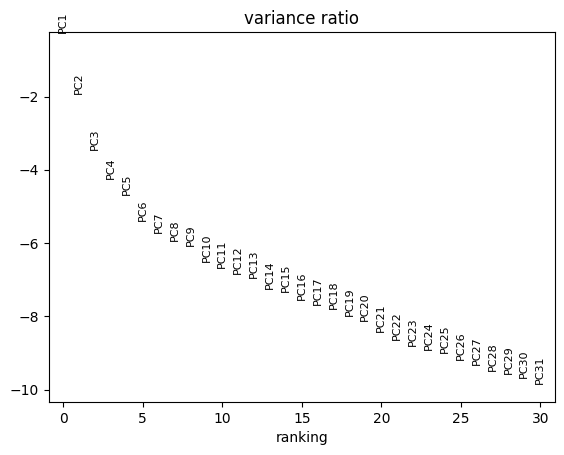

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)


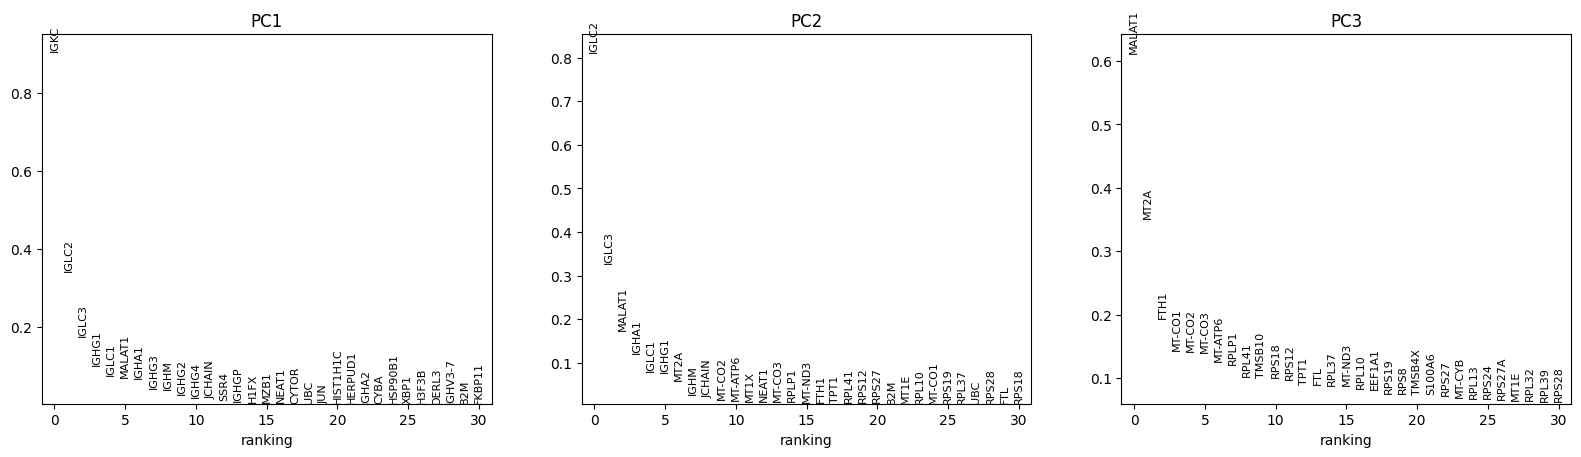

In [9]:
sc.pl.pca_loadings(adata, include_lowest=False)


In [10]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


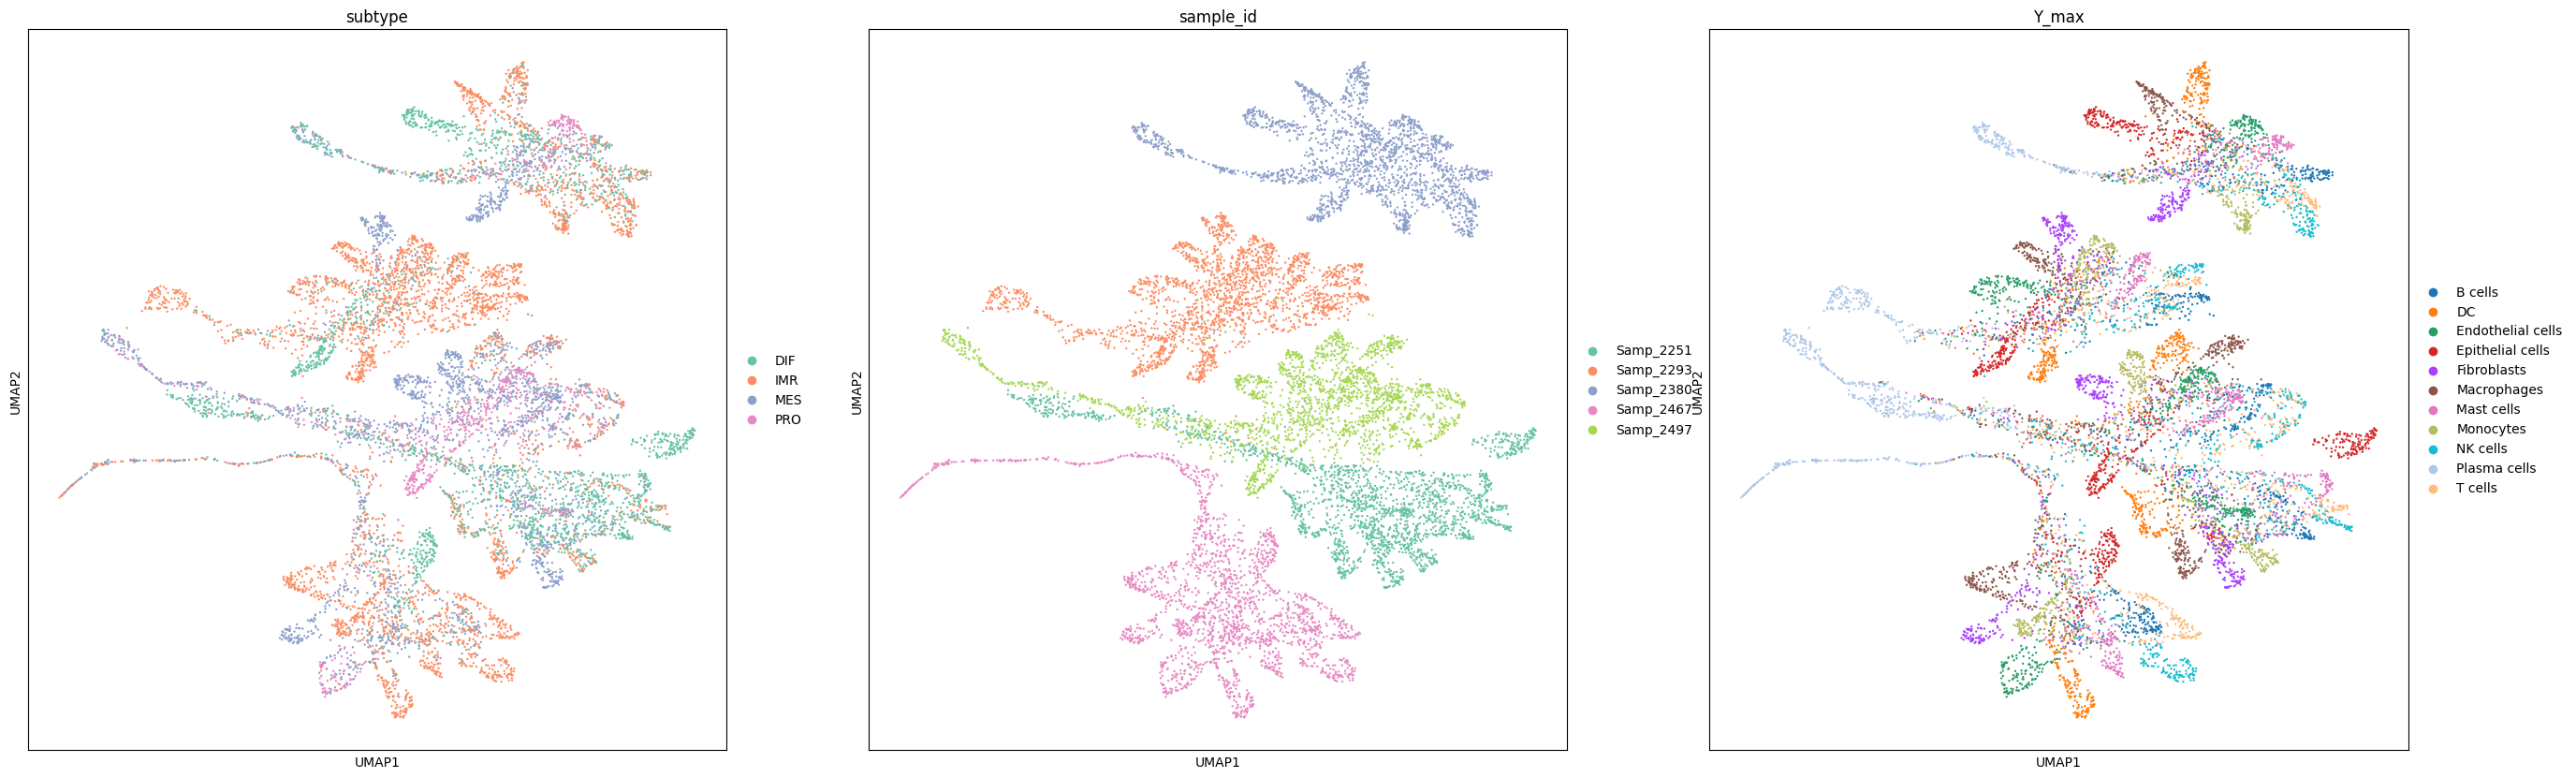

In [11]:
from matplotlib.pyplot import rc_context

# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color=['subtype', 'sample_id', "Y_max"])


In [12]:
tab = adata.obs.groupby(['Y_max', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
Y_max,,,,
B cells,287,374,251,65
DC,197,583,158,28
Endothelial cells,148,168,247,391
Epithelial cells,739,19,12,185
Fibroblasts,21,23,891,12
Macrophages,60,746,179,12
Mast cells,261,352,273,57
Monocytes,142,533,263,7
NK cells,210,537,149,70


In [13]:
tab = adata.obs.groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_2251,1237,383,433,47
Samp_2293,290,1584,226,0
Samp_2380,678,785,459,178
Samp_2467,266,1137,603,94
Samp_2497,46,283,1176,595


In [14]:
set(adata.obs.Y_max)

{'B cells',
 'DC',
 'Endothelial cells',
 'Epithelial cells',
 'Fibroblasts',
 'Macrophages',
 'Mast cells',
 'Monocytes',
 'NK cells',
 'Plasma cells',
 'T cells'}

In [15]:
tab = adata.obs.iloc[np.where(adata.obs.Y_max == "Epithelial cells")[0]].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_2251,180,0,0,0
Samp_2293,190,7,0,0
Samp_2380,193,0,0,0
Samp_2467,175,12,12,1
Samp_2497,1,0,0,184


# set the label for Diff Exp

In [16]:
# set the label

cell_type_vec = np.array(["DIF_total"]*adata.obs.sample_id.shape[0])
pro_label_idx = np.where(adata.obs.sample_id.isin(["Samp_2497"]) )[0]
cell_type_vec[pro_label_idx] = "PRO_total"

adata.obs['subtype_total'] = cell_type_vec



In [17]:
tab = adata.obs.iloc[np.where(adata.obs.Y_max == "Fibroblasts")[0]].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_2251,9,0,189,0
Samp_2293,7,23,187,0
Samp_2380,5,0,178,4
Samp_2467,0,0,174,1
Samp_2497,0,0,163,7


In [18]:
immune_ct = ["Monocytes"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_2251,48,45,7,0
Samp_2293,0,100,0,0
Samp_2380,14,81,5,0
Samp_2467,1,98,1,0
Samp_2497,0,0,100,0


In [19]:
immune_ct = ["Macrophages"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_2251,7,85,8,0
Samp_2293,0,100,0,0
Samp_2380,0,100,0,0
Samp_2467,0,100,0,0
Samp_2497,0,50,50,0


In [20]:
immune_ct = ["T cells"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
Samp_2251,55,43,2,0
Samp_2293,1,99,0,0
Samp_2380,23,73,3,1
Samp_2467,0,94,6,0
Samp_2497,1,56,35,8


# Differential Expression

In [21]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e6)

# log data
sc.pp.log1p(adata)

# get high variance genes
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# now process the counts further for doing  
# analysis and the cell clustering
#adata = adata[:, adata.var.highly_variable]

# scale the genes
sc.pp.scale(adata, max_value=10)

# calculate PCA
sc.tl.pca(adata, n_comps=20)

# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


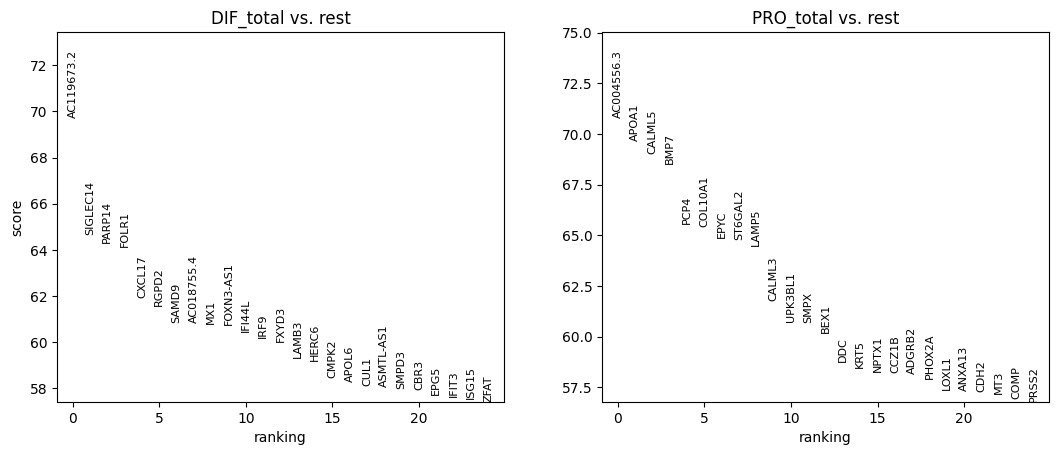

In [22]:
sc.tl.rank_genes_groups(adata, 'subtype_total', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

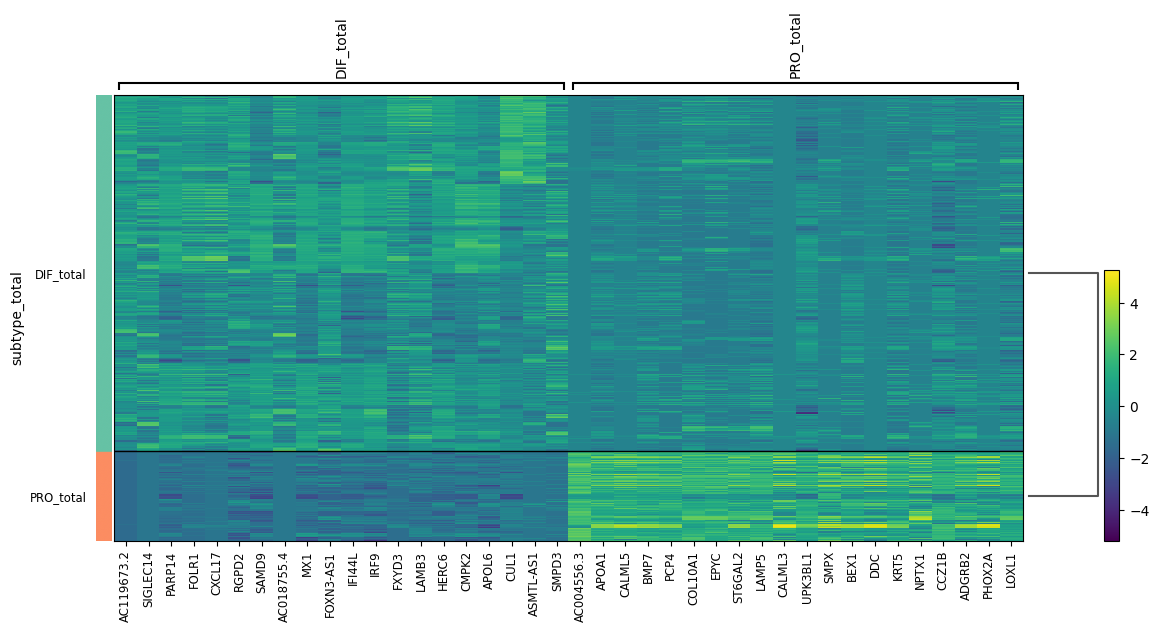

In [23]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=20, key="wilcoxon", groupby="subtype_total", show_gene_labels=True)


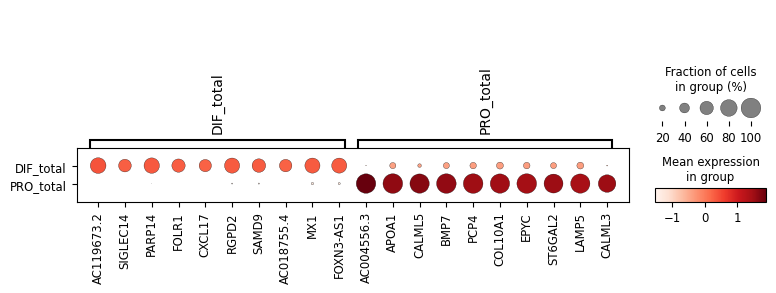

In [24]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, key="wilcoxon", groupby="subtype_total")


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


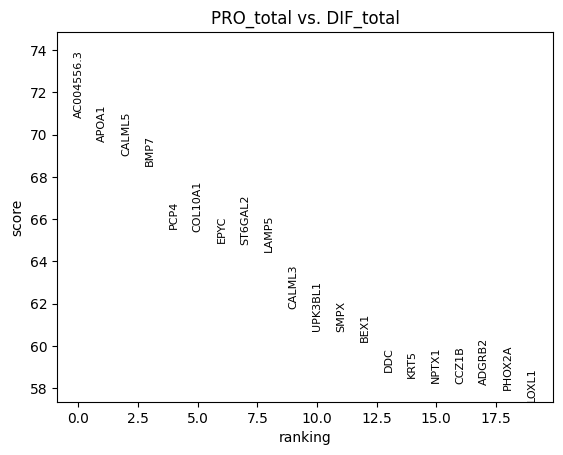

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


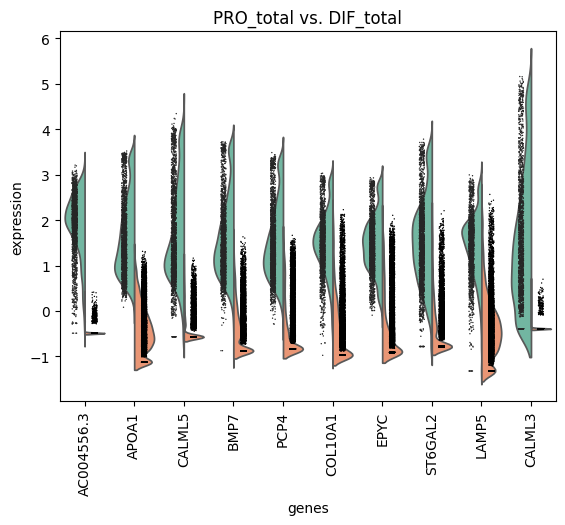

In [25]:
sc.tl.rank_genes_groups(adata, 'subtype_total', groups=['PRO_total'], reference='DIF_total', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['PRO_total'], n_genes=20)
sc.pl.rank_genes_groups_violin(adata, groups='PRO_total', n_genes=10)


In [26]:
wc = adata.uns['wilcoxon']['names']["PRO_total"]
wc[0:100]

array(['AC004556.3', 'APOA1', 'CALML5', 'BMP7', 'PCP4', 'COL10A1', 'EPYC',
       'ST6GAL2', 'LAMP5', 'CALML3', 'UPK3BL1', 'SMPX', 'BEX1', 'DDC',
       'KRT5', 'NPTX1', 'CCZ1B', 'ADGRB2', 'PHOX2A', 'LOXL1', 'ANXA13',
       'CDH2', 'MT3', 'COMP', 'PRSS2', 'TUBB2B', 'IFT52', 'AC139491.8',
       'PRSS33', 'AC012499.1', 'SFRP4', 'KRTAP2-3', 'SFRP2', 'PIANP',
       'GPX7', 'SCGB3A1', 'SSR2', 'SPATA2L', 'SOX11', 'NKD2', 'CCN2',
       'IGLON5', 'CAMK2N2', 'DPP10-AS1', 'AL442003.1', 'CLDN11', 'CCNI',
       'ANKRD9', 'CNTN1', 'TTC3', 'GCSH', 'WNT4', 'LMO7-AS1', 'C17orf107',
       'CTHRC1', 'COL11A1', 'MFAP2', 'KLHDC8A', 'ZNF880', 'AL354822.1',
       'ZIC2', 'MATN3', 'PSTK', 'AC007009.1', 'RPL9', 'FGFRL1', 'RPS10',
       'RNF212', 'COL8A1', 'RPL5', 'PTPRT', 'EEF2', 'NSG1', 'CLEC18B',
       'AL365259.1', 'ARSE', 'CIRBP', 'PPBP', 'APLP1', 'SFRP5', 'RPS14',
       'TAGLN', 'PODNL1', 'SCT', 'HBB', 'RPL3', 'RPL13', 'EEF1G', 'OBP2B',
       'RPL7A', 'BARX1', 'BMPR1B-DT', 'CDH18', 'RACK1', 'M

# Plot results

In [27]:
# get consensusOV genes
consensus_genes = pd.read_csv(consensus_ov_gene_path)
consensus_genes = np.intersect1d(consensus_genes.gene, adata.var.gene_ids)

adata = adata[:, consensus_genes]

consensus_genes

array(['ADAMDEC1', 'ANXA1', 'APOBEC3G', 'BLMH', 'CACNA1C', 'CALD1',
       'CASP1', 'CLU', 'COL4A6', 'COL5A1', 'COL8A1', 'COPS3', 'CXCL10',
       'DDR2', 'DLC1', 'DLEC1', 'EFS', 'EVI2A', 'F2R', 'FCER1G', 'FN1',
       'FSCN1', 'FUT2', 'GAS7', 'GIMAP5', 'IL21R', 'KIF1A', 'KMO', 'LAG3',
       'LAMB1', 'LAPTM5', 'LCN2', 'LGALS1', 'MAPRE1', 'MAPRE2', 'MARCKS',
       'MARCKSL1', 'MFAP2', 'MGLL', 'MLPH', 'MMP14', 'NBL1', 'NETO2',
       'NNMT', 'NUAK1', 'PALLD', 'PCOLCE', 'PDPN', 'PDZK1IP1', 'PKIA',
       'PTGER2', 'RHOBTB3', 'RIN1', 'RUNX1', 'SALL2', 'SCGB2A2', 'SLA',
       'SLC31A2', 'SLC37A1', 'SMARCD1', 'SSH3', 'STEAP3', 'STMN1',
       'TCF7L1', 'TNFRSF14', 'TPST1', 'UBE2L6', 'WIPF1'], dtype=object)

In [28]:
len(consensus_genes)

68

In [29]:
adata

View of AnnData object with n_obs × n_vars = 10500 × 68
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'Plasma cells', 'B cells', 'T cells', 'Endothelial cells', 'Monocytes', 'Fibroblasts', 'NK cells', 'Epithelial cells', 'DC', 'Macrophages', 'Mast cells', 'IMR_consensus', 'DIF_consensus', 'PRO_consensus', 'MES_consensus', 'subtype', 'Y_max', 'subtype_total'
    var: 'gene_ids', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'subtype_colors', 'sample_id_colors', 'Y_max_colors', 'log1p', 'wilcoxon', 'subtype_total_colors', 'dendrogram_subtype_total', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [30]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,Plasma cells,B cells,T cells,Endothelial cells,Monocytes,...,DC,Macrophages,Mast cells,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max,subtype_total
0,Samp_2251,CTRL,Train,random,sc_ref,0.015000,0.085000,0.360000,0.045000,0.300000,...,0.010000,0.040000,0.035000,0.306,0.178,0.086,0.430,MES,T cells,DIF_total
1,Samp_2251,CTRL,Train,random,sc_ref,0.070000,0.070000,0.035000,0.100000,0.165000,...,0.140000,0.030000,0.140000,0.124,0.266,0.222,0.388,MES,Monocytes,DIF_total
2,Samp_2251,CTRL,Train,random,sc_ref,0.225000,0.030000,0.070000,0.175000,0.065000,...,0.120000,0.025000,0.075000,0.068,0.838,0.048,0.046,DIF,Plasma cells,DIF_total
3,Samp_2251,CTRL,Train,random,sc_ref,0.175000,0.010000,0.040000,0.020000,0.470000,...,0.170000,0.060000,0.005000,0.384,0.386,0.082,0.148,DIF,Monocytes,DIF_total
4,Samp_2251,CTRL,Train,random,sc_ref,0.010000,0.065000,0.010000,0.130000,0.015000,...,0.320000,0.005000,0.100000,0.062,0.830,0.048,0.060,DIF,DC,DIF_total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,Samp_2497,CTRL,Train,cell_type_specific,sc_ref,0.026604,0.002890,0.010341,0.047804,0.020454,...,0.023407,0.025306,0.772491,0.076,0.234,0.412,0.278,PRO,Mast cells,PRO_total
10496,Samp_2497,CTRL,Train,cell_type_specific,sc_ref,0.002116,0.001691,0.003243,0.000644,0.003703,...,0.000648,0.004316,0.972817,0.160,0.192,0.210,0.438,MES,Mast cells,PRO_total
10497,Samp_2497,CTRL,Train,cell_type_specific,sc_ref,0.025838,0.005547,0.004899,0.004423,0.009855,...,0.047177,0.006951,0.872177,0.134,0.208,0.190,0.468,MES,Mast cells,PRO_total
10498,Samp_2497,CTRL,Train,cell_type_specific,sc_ref,0.010354,0.000653,0.008314,0.002285,0.004506,...,0.001800,0.003537,0.959781,0.142,0.146,0.172,0.540,MES,Mast cells,PRO_total


In [31]:
adata.var

,gene_ids,mean,std
gene_ids,,,
ADAMDEC1,ADAMDEC1,1.260650,1.153184
ANXA1,ANXA1,6.296816,0.711701
APOBEC3G,APOBEC3G,3.282453,1.024701
BLMH,BLMH,2.751390,0.556828
CACNA1C,CACNA1C,2.040868,1.452376
...,...,...,...
TCF7L1,TCF7L1,1.919512,1.017113
TNFRSF14,TNFRSF14,3.711708,0.453982
TPST1,TPST1,2.975435,1.080305


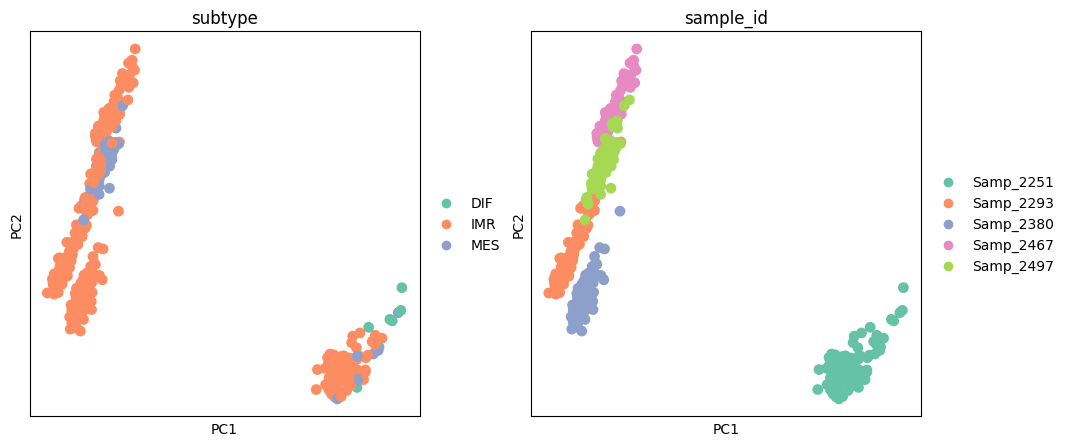

In [32]:
immune_ct = ["Macrophages"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'])

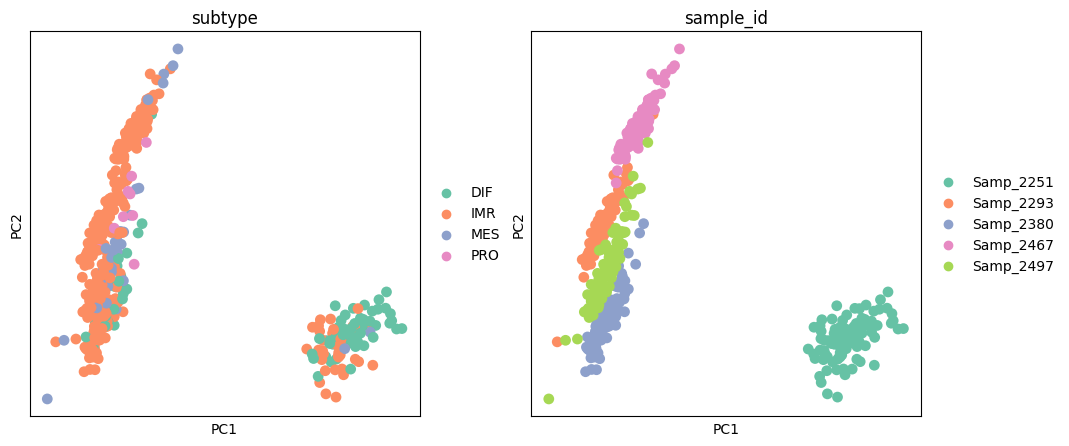

In [33]:
immune_ct = ["T cells"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'])

In [34]:
adata.obs.columns

Index(['sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type',
       'Plasma cells', 'B cells', 'T cells', 'Endothelial cells', 'Monocytes',
       'Fibroblasts', 'NK cells', 'Epithelial cells', 'DC', 'Macrophages',
       'Mast cells', 'IMR_consensus', 'DIF_consensus', 'PRO_consensus',
       'MES_consensus', 'subtype', 'Y_max', 'subtype_total'],
      dtype='object')

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/natalie/.pyenv/versions/3.12.7/lib/python3.12/contextlib.py:144: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


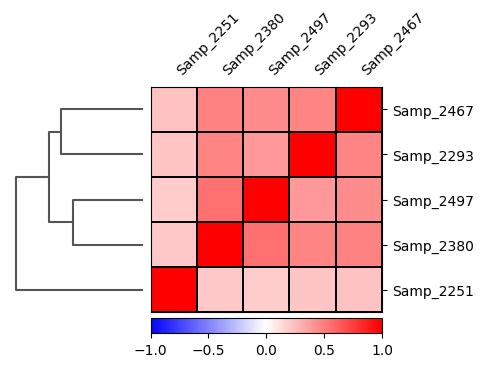

In [35]:
immune_ct = ["Epithelial cells"]
subtype_ct = ["DIF", "PRO"]

idx = np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") 
idx = np.where(np.logical_and(idx, adata.obs.subtype.isin(subtype_ct)) )[0]

sc.pl.correlation_matrix(adata[idx], groupby="sample_id")

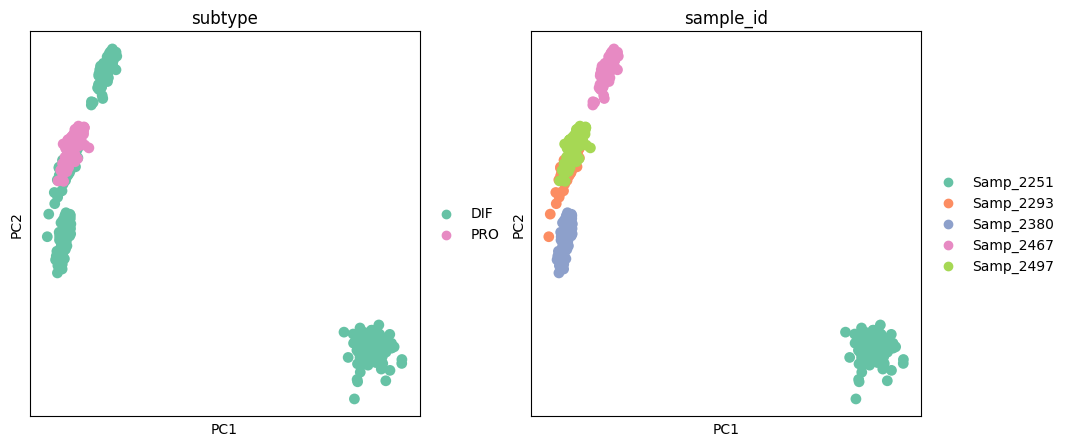

In [36]:
immune_ct = ["Epithelial cells"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'])

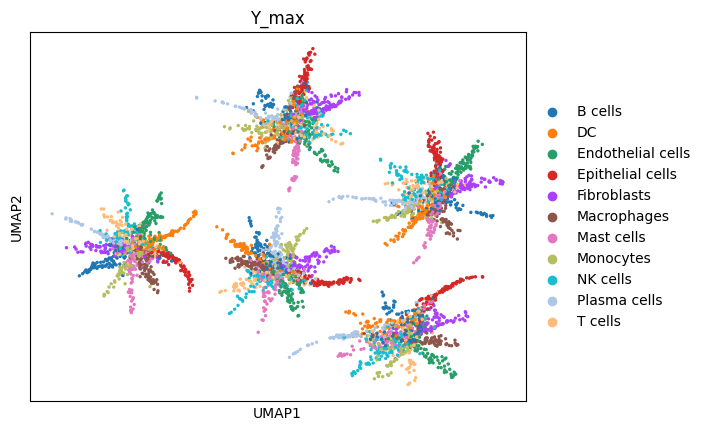

In [37]:
idx = np.where(adata.obs.cell_prop_type == "random" )[0]

sc.pl.umap(adata[idx], color='Y_max')